In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from imblearn.metrics import geometric_mean_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, Conv1D, Flatten, Dropout

In [4]:
file_path = "/content/drive/MyDrive/Minor/traffic_weather_full2020.csv"
df = pd.read_csv(file_path)

<ipython-input-4-d787b8d073af>:2: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
X = df.iloc[:, :-1]

# Assuming '5 Minutes' column contains the date and time string
# Convert '5 Minutes' column to datetime objects
df['5 Minutes'] = pd.to_datetime(df['5 Minutes'])

# Extract numerical features from the datetime objects
# For example, extract hour, day of week, etc.
df['Hour'] = df['5 Minutes'].dt.hour
df['DayOfWeek'] = df['5 Minutes'].dt.dayofweek

# Now, select the columns you want to scale, excluding the original '5 Minutes' column
X = df[['Flow', 'Hour', 'DayOfWeek',  # ... other numerical columns
       ]]  # Exclude '5 Minutes' column

# Proceed with scaling
min_max_scaler = MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X)
df_min_max = pd.DataFrame(X_min_max, columns=X.columns)
print("\n===== Min-Max Scaling =====\n")
print(df_min_max)


===== Min-Max Scaling =====

           Flow  Hour  DayOfWeek
0      0.355021   0.0   0.833333
1      0.386139   0.0   0.833333
2      0.367751   0.0   0.833333
3      0.353607   0.0   0.833333
4      0.304102   0.0   0.833333
...         ...   ...        ...
34818  0.135785   1.0   1.000000
34819  0.158416   1.0   1.000000
34820  0.134371   1.0   1.000000
34821  0.127298   1.0   1.000000
34822  0.107496   1.0   1.000000

[34823 rows x 3 columns]


In [6]:
# Assuming '5 Minutes' column contains the date and time string
# Convert '5 Minutes' column to datetime objects
df['5 Minutes'] = pd.to_datetime(df['5 Minutes'])

# Extract numerical features from the datetime objects
# For example, extract hour, day of week, etc.
df['Hour'] = df['5 Minutes'].dt.hour
df['DayOfWeek'] = df['5 Minutes'].dt.dayofweek

# Now, select the columns you want to scale, excluding the original '5 Minutes' column
# Make sure to include all relevant numerical features and exclude non-numerical columns.
X = df[['Flow', 'Hour', 'DayOfWeek']]  # Add other numerical columns as needed

# Proceed with scaling
standard_scaler = StandardScaler()
X_standardized = standard_scaler.fit_transform(X)
df_standardized = pd.DataFrame(X_standardized, columns=X.columns)
print("\n===== Standardization (Z-score) =====\n")
print(df_standardized)


===== Standardization (Z-score) =====

           Flow      Hour  DayOfWeek
0     -0.395296 -1.663118   0.975542
1     -0.272366 -1.663118   0.975542
2     -0.345006 -1.663118   0.975542
3     -0.400884 -1.663118   0.975542
4     -0.596455 -1.663118   0.975542
...         ...       ...        ...
34818 -1.261397  1.661006   1.473173
34819 -1.171993  1.661006   1.473173
34820 -1.266985  1.661006   1.473173
34821 -1.294924  1.661006   1.473173
34822 -1.373152  1.661006   1.473173

[34823 rows x 3 columns]


In [7]:
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X)
df_normalized = pd.DataFrame(X_normalized, columns=X.columns)
print("\n===== Normalization =====\n")
print(df_normalized)


===== Normalization =====

           Flow      Hour  DayOfWeek
0      0.999891  0.000000   0.014791
1      0.999904  0.000000   0.013888
2      0.999896  0.000000   0.014408
3      0.999890  0.000000   0.014835
4      0.999863  0.000000   0.016554
...         ...       ...        ...
34818  0.991670  0.124636   0.032514
34819  0.992942  0.114762   0.029938
34820  0.991579  0.125309   0.032689
34821  0.991103  0.128787   0.033597
34822  0.989534  0.139627   0.036425

[34823 rows x 3 columns]


In [8]:
# Separating features and target
# Exclude the '5 Minutes' column from features
X = df[['Flow', 'Hour', 'DayOfWeek']]  # Include other relevant numerical features
y = df.iloc[:, -1]   # Target

# Feature Selection using Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X, y)

# Feature Selection using Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Get feature importance scores
dt_importances = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print the top features
print("Top Features Selected by Decision Tree:")
print(dt_importances[dt_importances > 0.01])  # Display features with importance > 0.01

print("\nTop Features Selected by Random Forest:")
print(rf_importances[rf_importances > 0.01])  # Display features with importance > 0.01

Top Features Selected by Decision Tree:
DayOfWeek    1.0
dtype: float64

Top Features Selected by Random Forest:
DayOfWeek    0.947747
Flow         0.037478
Hour         0.014776
dtype: float64


In [9]:
# Separating features and target
# Select only numerical features for scaling
X = df[['Flow', 'Hour', 'DayOfWeek']]  # Include other relevant numerical features if any
y = df.iloc[:, -1]   # Target

# Standardizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
# Decision Tree Classification
print("Decision Tree Classifier:")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted')
recall_dt = recall_score(y_test, y_pred_dt, average='weighted')
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
gmean_dt = geometric_mean_score(y_test, y_pred_dt, average='weighted')


# Random Forest Classification
print("Random Forest Classifier:")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
gmean_rf = geometric_mean_score(y_test, y_pred_rf, average='weighted')


# CNN Classification
print("CNN Classifier:")
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=-1)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')
gmean_cnn = geometric_mean_score(y_test, y_pred_cnn, average='weighted')


# ANN Classification
print("ANN Classifier:")
ann_model = Sequential()
ann_model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
ann_model.add(Dense(units=32, activation='relu'))
ann_model.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes
ann_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ann_model.fit(X_train, y_train, epochs=10, batch_size=32)
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=-1)
accuracy_ann = accuracy_score(y_test, y_pred_ann)
precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
f1_ann = f1_score(y_test, y_pred_ann, average='weighted')
gmean_ann = geometric_mean_score(y_test, y_pred_ann, average='weighted')


# RNN Classification
print("RNN Classifier:")
rnn_model = Sequential()
rnn_model.add(GRU(units=64, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=10, batch_size=32)
y_pred_rnn = np.argmax(rnn_model.predict(np.expand_dims(X_test, axis=2)), axis=-1)
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn, average='weighted')
recall_rnn = recall_score(y_test, y_pred_rnn, average='weighted')
f1_rnn = f1_score(y_test, y_pred_rnn, average='weighted')
gmean_rnn = geometric_mean_score(y_test, y_pred_rnn, average='weighted')


# LSTM Classification
print("LSTM Classifier:")
lstm_model = Sequential()
lstm_model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(units=10, activation='softmax'))  # Assuming 10 classes
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(np.expand_dims(X_train, axis=2), y_train, epochs=10, batch_size=32)
y_pred_lstm = np.argmax(lstm_model.predict(np.expand_dims(X_test, axis=2)), axis=-1)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')
gmean_lstm = geometric_mean_score(y_test, y_pred_lstm, average='weighted')


# SVM Classification
print("SVM Classifier:")
from sklearn.svm import SVC
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
gmean_svm = geometric_mean_score(y_test, y_pred_svm, average='weighted')


# Multi-SVM Classification
print("Multi-SVM Classifier:")
from sklearn.multiclass import OneVsRestClassifier
multi_svm_classifier = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
multi_svm_classifier.fit(X_train, y_train)
y_pred_multi_svm = multi_svm_classifier.predict(X_test)
accuracy_multi_svm = accuracy_score(y_test, y_pred_multi_svm)
precision_multi_svm = precision_score(y_test, y_pred_multi_svm, average='weighted')
recall_multi_svm = recall_score(y_test, y_pred_multi_svm, average='weighted')
f1_multi_svm = f1_score(y_test, y_pred_multi_svm, average='weighted')
gmean_multi_svm = geometric_mean_score(y_test, y_pred_multi_svm, average='weighted')

Decision Tree Classifier:
Random Forest Classifier:
CNN Classifier:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5368 - loss: 1.4161
Epoch 2/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9921 - loss: 0.3280
Epoch 3/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 0.0787
Epoch 4/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0250
Epoch 5/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 0.0105
Epoch 6/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 0.0051
Epoch 7/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 8/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 9/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 8.7036e-04
Epoch 10/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 5.0981e-04
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ANN Classifier:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5984 - loss: 1.1510
Epoch 2/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 0.0179
Epoch 3/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 4/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 8.4395e-04
Epoch 5/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 3.7278e-04
Epoch 6/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 1.0000 - loss: 1.8707e-04
Epoch 7/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 1.0000 - loss: 1.0125e-04
Epoch 8/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 1.0000 - loss: 5.6359e-05
Epoch 9/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 3.2489e-05
Epoch 10/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 1.9040e-05
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RNN Classifier:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6115 - loss: 1.3273
Epoch 2/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 1.0000 - loss: 0.2200
Epoch 3/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 0.0370
Epoch 4/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 0.0102
Epoch 5/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 6/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 7/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 9.7308e-04
Epoch 8/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 5.3130e-04
Epoch 9/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 3.0171e-04
Epoch 10/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 1.7496e-04
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM Classifier:
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


871/871 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5418 - loss: 1.4711
Epoch 2/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 0.3618
Epoch 3/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 0.1126
Epoch 4/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 0.0389
Epoch 5/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.0000 - loss: 0.0163
Epoch 6/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 0.0078
Epoch 7/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 8/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 9/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 10/10
871/871 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 1.0000 - loss: 7.2593e-04
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
SVM Classifier:
Multi-SVM Classifier:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
performance_evaluation = {
    'Classifier': ['Decision Tree', 'Random Forest', 'CNN', 'ANN', 'RNN', 'LSTM', 'SVM', 'Multi-SVM'],
    'Accuracy': [accuracy_dt, accuracy_rf, accuracy_cnn, accuracy_ann, accuracy_rnn, accuracy_lstm, accuracy_svm, accuracy_multi_svm],
    'Precision': [precision_dt, precision_rf, precision_cnn, precision_ann, precision_rnn, precision_lstm, precision_svm, precision_multi_svm],
    'Recall': [recall_dt, recall_rf, recall_cnn, recall_ann, recall_rnn, recall_lstm, recall_svm, recall_multi_svm],
    'F1-Score': [f1_dt, f1_rf, f1_cnn, f1_ann, f1_rnn, f1_lstm, f1_svm, f1_multi_svm],
    'G-Mean': [gmean_dt, gmean_rf, gmean_cnn, gmean_ann, gmean_rnn, gmean_lstm, gmean_svm, gmean_multi_svm]
}

performance_df = pd.DataFrame(performance_evaluation)
performance_df

,Classifier,Accuracy,Precision,Recall,F1-Score,G-Mean
0,Decision Tree,1.000000,1.000000,1.000000,1.000000,1.000000
1,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
2,CNN,1.000000,1.000000,1.000000,1.000000,1.000000
3,ANN,1.000000,1.000000,1.000000,1.000000,1.000000
4,RNN,1.000000,1.000000,1.000000,1.000000,1.000000
5,LSTM,1.000000,1.000000,1.000000,1.000000,1.000000
6,SVM,1.000000,1.000000,1.000000,1.000000,1.000000
7,Multi-SVM,0.523762,0.461034,0.523762,0.485719,0.694539


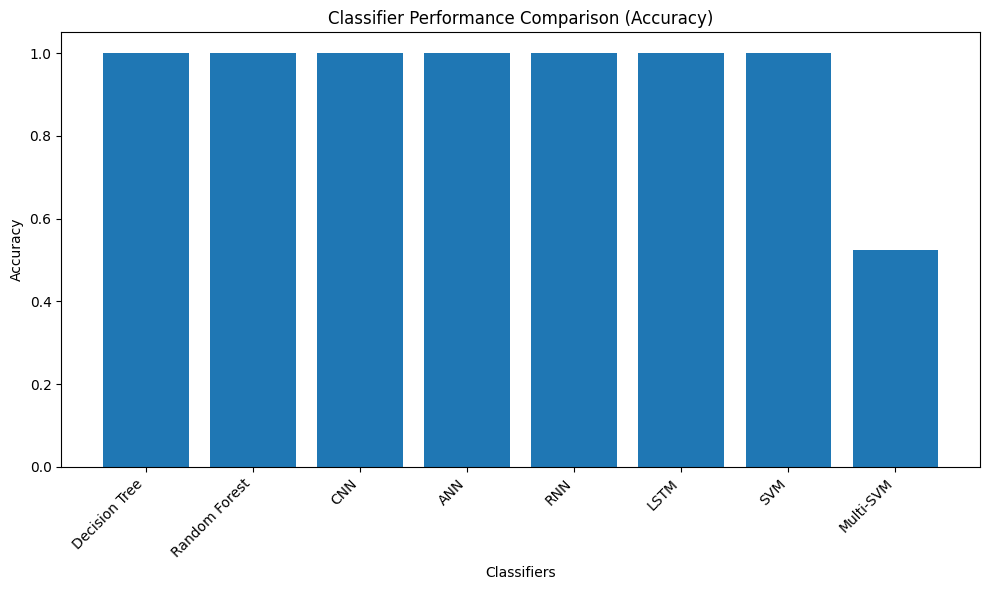

In [12]:
# Assuming performance_df is your DataFrame containing classifier performance metrics
classifiers = performance_df['Classifier']
accuracy = performance_df['Accuracy']

plt.figure(figsize=(10, 6))
plt.bar(classifiers, accuracy)
plt.xlabel("Classifiers")
plt.ylabel("Accuracy")
plt.title("Classifier Performance Comparison (Accuracy)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# You can create similar graphs for other metrics like Precision, Recall, F1-Score, and G-Mean
# by replacing 'accuracy' with the corresponding column from your performance_df.

In [13]:
# Assuming you want to classify hours into "Busy", "Average Busy", and "Not Busy" based on traffic flow.
# You can adjust the thresholds based on your specific definition of busy hours.

# Define thresholds for classifying traffic flow
busy_threshold = 0.8  # Example: Flow above 0.8 is considered busy
average_busy_threshold = 0.5  # Example: Flow between 0.5 and 0.8 is considered average busy

# Create a new column 'Traffic Category' based on Flow values
def classify_traffic(flow):
    if flow > busy_threshold:
        return 'Busy'
    elif flow > average_busy_threshold:
        return 'Average Busy'
    else:
        return 'Not Busy'

df['Traffic Category'] = df['Flow'].apply(classify_traffic)

# Encode 'Traffic Category' to numerical values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Traffic Category'] = le.fit_transform(df['Traffic Category'])


# Separating features and target
X = df[['Hour']]  # Using only 'Hour' as a feature
y = df['Traffic Category']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Based on the provided code and the nature of the problem (classifying hours based on traffic flow),
# Random Forest appears to be a good choice. It handles non-linear relationships well and is relatively robust.

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
gmean = geometric_mean_score(y_test, y_pred, average='weighted')

print("Random Forest Classifier:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("G-Mean:", gmean)

# You can further analyze the results by creating a confusion matrix and checking feature importance.


Random Forest Classifier:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
G-Mean: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Group data by hour and calculate the average flow for each hour
hourly_flow = df.groupby('Hour')['Flow'].mean()

# Define thresholds for busy, average busy, and not busy
busy_threshold = hourly_flow.quantile(0.75)  # 75th percentile
not_busy_threshold = hourly_flow.quantile(0.25)  # 25th percentile

# Classify each hour based on the average flow
hour_classification = []
for hour in range(24):
  if hourly_flow[hour] >= busy_threshold:
    hour_classification.append("Busy")
  elif hourly_flow[hour] <= not_busy_threshold:
      hour_classification.append("Not Busy")
  else:
    hour_classification.append("Average Busy")

# Create a DataFrame to display the results
hour_classification_df = pd.DataFrame({
    'Hour': range(24),
    'Classification': hour_classification
})

# Print the DataFrame
hour_classification_df

,Hour,Classification
0,0,Not Busy
1,1,Not Busy
2,2,Not Busy
3,3,Not Busy
4,4,Not Busy
5,5,Average Busy
6,6,Average Busy
7,7,Average Busy
8,8,Average Busy
9,9,Average Busy


In [ ]:
# Find the hour with the maximum average flow
busiest_hour = hourly_flow.idxmax()

print(f"The Peak hour is: {busiest_hour}")

The Peak hour is: 15


In [ ]:
# Find the hour with the minimum average flow
most_idle_hour = hourly_flow.idxmin()

print(f"The most idle hour is: {most_idle_hour}")


The most idle hour is: 3


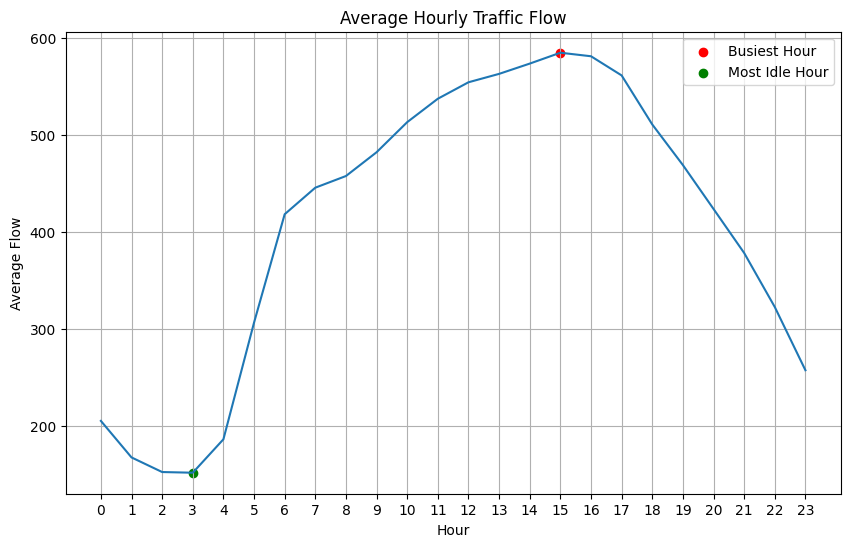

In [ ]:
# prompt: show busiest hour and idle hour in graph

# Plot the average flow for each hour to visualize busiest and idle hours
plt.figure(figsize=(10, 6))
plt.plot(hourly_flow.index, hourly_flow.values)
plt.xlabel("Hour")
plt.ylabel("Average Flow")
plt.title("Average Hourly Traffic Flow")
plt.xticks(range(24))  # Show all hours on the x-axis
plt.grid(True)

# Mark the busiest and idle hours on the plot
plt.scatter(busiest_hour, hourly_flow[busiest_hour], color='red', label='Busiest Hour')
plt.scatter(most_idle_hour, hourly_flow[most_idle_hour], color='green', label='Most Idle Hour')

plt.legend()
plt.show()
